## Background
You've decided to treat yourself to a long holiday vacation in Honolulu, Hawaii! To help with my trip planning, I have done climate analysis on the area. 


## Observations



In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import datetime as dt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, select, Integer, Table, Column, MetaData



# Reflect Tables into SQLAlchemy ORM

In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [3]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)


In [4]:
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [5]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)



# Exploratory Climate Analysis

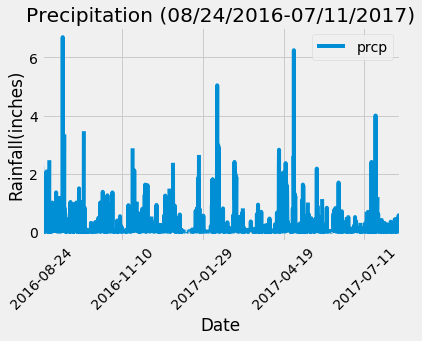

In [7]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results



# Calculate the date 1 year ago from the last data point in the database
last_day = session.query(Measurement.date).order_by(Measurement.id.desc()).first()
last_day = str(last_day).split("'")[1]
last_year = dt.datetime.strptime(last_day, "%Y-%m-%d")-dt.timedelta(365)
# Perform a query to retrieve the data and precipitation scores
yearly = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date>=last_year)
# Save the query results as a Pandas DataFrame and set the index to the date column
yearly_df = pd.DataFrame(yearly)
yearly_indexdate = yearly_df.set_index('date')
# Sort the dataframe by date
yearly_indexdate = yearly_indexdate.sort_index()
# Use Pandas Plotting with Matplotlib to plot the data
yearly_df = yearly_df.sort_values(by='date')
yearly_df.plot('date','prcp')
plt.tight_layout()
plt.xticks(rotation = 45)
plt.title("Precipitation (08/24/2016-07/11/2017)")
plt.xlabel("Date")
plt.ylabel("Rainfall(inches)")
plt.savefig("Images/precipitation.png")
plt.show()



In [8]:
# Use Pandas to calcualte the summary statistics for the precipitation data
yearly_indexdate.describe()


prcp
count  2015.000000
mean      0.176462
std       0.460288
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000

In [9]:
# Design a query to show how many stations are available in this dataset?
station_query = pd.DataFrame(session.query(Station.station).group_by(Station.station))

print(f"There are {len(station_query)} Stations.")
station_query



There are 9 Stations.


station
0  USC00511918
1  USC00513117
2  USC00514830
3  USC00516128
4  USC00517948
5  USC00518838
6  USC00519281
7  USC00519397
8  USC00519523

In [10]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_query = session.query(Measurement.station,func.count(Measurement.station))\
                            .group_by(Measurement.station)\
                            .order_by(func.count(Measurement.station).desc())\
                            .all()
pd.DataFrame(station_query, columns=["Station ID", "Number of Measurements"])


Station ID  Number of Measurements
0  USC00519281                    2772
1  USC00519397                    2724
2  USC00513117                    2709
3  USC00519523                    2669
4  USC00516128                    2612
5  USC00514830                    2202
6  USC00511918                    1979
7  USC00517948                    1372
8  USC00518838                     511

In [11]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active =session.query(Measurement.station,\
                           func.min(Measurement.tobs),\
                           func.max(Measurement.tobs),\
                           func.avg(Measurement.tobs)).\
                           filter(Measurement.station == station_query[0][0]).all()
    
pd.DataFrame(most_active[0], index =["Station ID", "Min Temp", "Max Temp", "Avg Temp"]).T



Station ID Min Temp Max Temp Avg Temp
0  USC00519281       54       85  71.6638

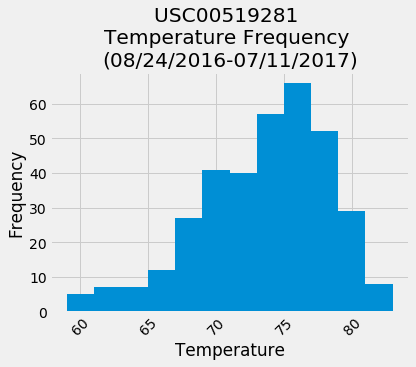

In [12]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_temp_query = session.query(Measurement.station,func.count(Measurement.tobs))\
                            .group_by(Measurement.station)\
                            .order_by(func.count(Measurement.station).desc())\
                            .first()


yearly = session.query(Measurement.tobs).filter(Measurement.date>=last_year).filter(Measurement.station ==station_temp_query[0])
# Save the query results as a Pandas DataFrame and set the index to the date column
yearly_df = pd.DataFrame(yearly, columns=['Temperature'])
yearly_df['Temperature'].plot.hist(bins=12)
plt.tight_layout()
plt.xticks(rotation = 45)
plt.title(f"{station_temp_query[0]} \nTemperature Frequency \n(08/24/2016-07/11/2017)")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.savefig("Images/station-histogram.png")
plt.show()



## Bonus Challenge Assignment

In [13]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return pd.DataFrame(session.query(func.min(Measurement.tobs),
                                      func.avg(Measurement.tobs),
                                      func.max(Measurement.tobs)).\
                                      filter(Measurement.date >= start_date).\
                                      filter(Measurement.date <= end_date).all(),\
                                      columns=["Minimum Temperature",
                                               "Average Temperature",
                                               "Maximum Temperature"])

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))



   Minimum Temperature  Average Temperature  Maximum Temperature
0                 62.0            69.571429                 74.0


In [14]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip_df =calc_temps(last_year.strftime("%Y-%m-%d"),last_day)
my_trip_df


Minimum Temperature  Average Temperature  Maximum Temperature
0                 58.0            74.590583                 87.0

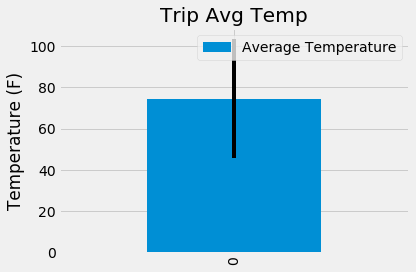

In [15]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
my_trip_df.plot.bar(y="Average Temperature",yerr = (my_trip_df["Maximum Temperature"][0]-my_trip_df["Minimum Temperature"][0]))

plt.title("Trip Avg Temp")
plt.savefig("images/temperature.png")
plt.ylabel("Temperature (F)")
plt.tight_layout()
plt.show()


In [16]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def calc_precipitation(start_date, end_date):
    """station, name, latitude, longitude, elevation, prcp for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        station, name, latitude, longitude, elevation, prcp for a list of dates.
    """
    
    return pd.DataFrame(session.query(Measurement.station,
                                      Station.name,
                                      Station.latitude,
                                      Station.longitude,
                                      Station.elevation,
                                      Measurement.prcp).\
                                      filter(Measurement.station == Station.station).\
                                      filter(Measurement.date >= start_date).\
                                      filter(Measurement.date <= end_date).all(),\
                                      columns=["Station",
                                               "Name",
                                               "Latitude",
                                               "Longitude",
                                               "Elevation",
                                               "Precipitation"])

# function usage example
print(calc_precipitation('2012-02-28', '2012-03-05').head())



       Station                  Name  Latitude  Longitude  Elevation  \
0  USC00519397  WAIKIKI 717.2, HI US   21.2716  -157.8168        3.0   
1  USC00519397  WAIKIKI 717.2, HI US   21.2716  -157.8168        3.0   
2  USC00519397  WAIKIKI 717.2, HI US   21.2716  -157.8168        3.0   
3  USC00519397  WAIKIKI 717.2, HI US   21.2716  -157.8168        3.0   
4  USC00519397  WAIKIKI 717.2, HI US   21.2716  -157.8168        3.0   

   Precipitation  
0           0.00  
1           0.00  
2           0.06  
3           0.00  
4           0.03  


In [17]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs),
           func.avg(Measurement.tobs),
           func.max(Measurement.tobs)]
    
    return session.query(*sel).\
                        filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")



[(62.0, 69.15384615384616, 77.0)]

In [18]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start = '2012-02-28'
trip_end = '2012-03-28'

start_datetime = dt.datetime.strptime(trip_start, "%Y-%m-%d")
end_datetime =  dt.datetime.strptime(trip_end, "%Y-%m-%d")
time_delta =end_datetime-start_datetime


# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
date_list =[]
full_date_list = []
for i in range(0, time_delta.days):
    curr_date = start_datetime+dt.timedelta(i)
    date_list.append(curr_date.strftime("%m-%d"))
    full_date_list.append(curr_date)

# Loop through the list of %m-%d strings and calculate the normals for each date
trip_dates = []
for date in date_list:
    trip_dates.append(daily_normals(date)[0])



In [19]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
my_df = pd.DataFrame(trip_dates, columns =["Minimum Temperature","Average Temperature","Maximum Temperature"])
my_df2 =pd.DataFrame(full_date_list, columns = ["Date"])

new_df = pd.merge(my_df,my_df2,left_index=True, right_index=True)
trip_df = new_df.set_index("Date")
trip_df.head()



Minimum Temperature  Average Temperature  Maximum Temperature
Date                                                                     
2012-02-28                 65.0            70.655172                 80.0
2012-02-29                 67.0            71.733333                 79.0
2012-03-01                 64.0            70.032787                 76.0
2012-03-02                 61.0            70.366667                 78.0
2012-03-03                 60.0            70.068966                 78.0

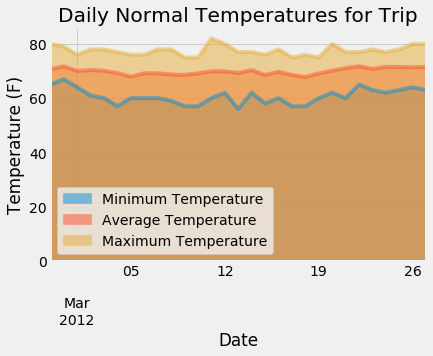

In [20]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot.area( stacked = False)
plt.ylabel("Temperature (F)")
plt.title("Daily Normal Temperatures for Trip")
plt.savefig("Images/daily-normals")
plt.show()



### Temperature Analysis I